In [4]:
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
import sys
sys.path.insert(0, '../zdrojaky/kf')
from trajectory import trajectory
np.set_printoptions(precision=2)

In [41]:
class KF():
    def __init__(self, A, B, H, R, Q):
        self.A = A
        self.B = B
        self.H = H
        self.R = R
        self.Q = Q
        self.P = np.eye(self.Q.shape[0]) * 10000
        self.x = np.ones(self.Q.shape[0])
        self.log_x = []
    
    def predict(self, u=None):
        xminus = self.A.dot(self.x)
        Pminus = self.A.dot(self.P).dot(self.A.T) + self.Q
        self.x = xminus
        self.P = Pminus
    
    def correct(self, yt):
        HPHT = self.H.dot(self.P).dot(self.H.T)
        zavorka_inv = np.linalg.inv(HPHT + self.R)
        K = self.P.dot(self.H.T).dot(zavorka_inv)
        innovation = yt - self.H.dot(self.x)
        xplus = self.x + K.dot(innovation)
        zavorka = np.eye(K.shape[0]) - K.dot(self.H)
        KRKT = K.dot(self.R).dot(K.T)
        Pplus = zavorka.dot(self.P).dot(zavorka.T) + KRKT
        self.x = xplus
        self.P = Pplus
    
    def log(self):
        self.log_x.append(self.x)

# Strukturní modely

Už známe klasické modely časových řad typu ARIMA. Existuje ale ještě jedna možnost, jak časové řady modelovat, a sice prostřednictvím tzv. strukturních modelů. Ty jsou modely stavovými, ovšem namísto koeficientů AR či MA částí modelujme přímo vývoj střední hodnoty, sezónních složek atd.

V tomto cvičení (které je současně testem) si zkusíme jeden z nejjednodušších a přitom ohromně mocných modelů: lokální lineární trend. Opět budeme mít pozorovanou veličinu $y_t$, která má tentokrát střední hodnotu $\mu$ a je zatížena normálním šumem $\varepsilon_t$. Střední hodnotu budeme rovněž modelovat, a sice jako veličinu, která je ovlivněna svou přechozí hodnotou $\mu_{t-1}$ a šumem $\xi_t$, ale vstupuje do ní i drift $\nu_t$. Jedná se tedy o náhodnou procházku s driftem. A abychom dokázali pochytat i dynamiku na střední hodnotě, budeme i samotný drift modelovat jako náhodnou procházku. V řeči statového modelu to bude vypadat následovně (dobře rozmyslete!):

$$
\begin{alignat}{2}
y_t &= \mu_t + \varepsilon_t, \qquad &\varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2), \\
\mu_t &= \mu_{t-1} + \nu_{t-1} + \xi_t, \qquad &\xi_t \sim \mathcal{N}(0, \sigma_{\xi}^2), \\
\nu_t &= \nu_{t-1} + \zeta_t, \qquad &\zeta_t \sim \mathcal{N}(0, \sigma_{\zeta}^2).
\end{alignat}
$$

Je důležité myslet na to, že pozorovaná veličina je $y_t$, zatímco nepozorovatelné $\mu_t$ a $\nu_t$ budeme uvažovat jako stavy.

Zkusíme si systém nasimulovat s nějakými hodnotami variancí (v kódu níže zadávám směrodatné odchylky kvůli scipy!):

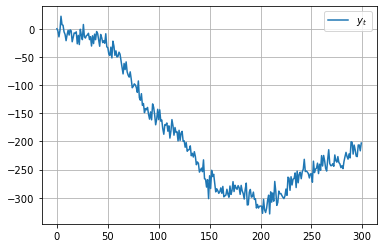

In [297]:
ndat = 300
pred = 50
sigma_epsilon = 10
sigma_xi = .9
sigma_zeta = .3
mu = np.zeros(ndat)
nu = np.zeros(ndat)
y = np.zeros(ndat)

for t in range(1, ndat):
    nu[t] = nu[t-1] + norm.rvs(scale=sigma_zeta)
    mu[t] = mu[t-1] + nu[t-1] + norm.rvs(scale=sigma_xi)
    y[t] = mu[t] + norm.rvs(scale=sigma_epsilon)
    
plt.plot(y, label=r'$y_t$')
plt.legend()
plt.show()

Zkuste si pustit simulaci víckrát, ať se seznámíte s flexibilitou modelu. Rovněž zkuste měnit variance jednotlivých šumů a pozorujte, jak se změny projevují (chce to pokaždé více běhů).

## Úkol 1:

Využijte Kalmanův filtr pro modelování výše uvedeného systému. Tj. sestavte matice (uveďte je zde), pusťte odhad a udělejte predikce i na např. 50 kroků za horizont dat. Vykreslete obrázky, přidejte diskusi o výsledcích.

## Úkol 2:

V souboru '20180224_Gp_part_5m.txt' naleznete měření z přístroje zjišťujícího tok elektronů a protonů v slunečním větru. Tento instrument je umístěn v družici [GOES-15](https://en.wikipedia.org/wiki/GOES_15). Vyberte sloupec s měřeními "Electrons at >2.0 Mev" a zkuste jej namodelovat pomocí modelu lokálního lineárního trendu. To znamená, že budete muset vyladit i (neznámé) hodnoty variancí šumu. Nedá to moc práce, ale chce to použít mozek :)

Výsledky opět vykreslete a diskutujte, nač jste přišli.